# Simple Wind/Solar/H2/Methanol Hybrid Plant Example
---
In this example, we will walk through the process of simulating a hybrid renewable energy system using the Hybrid Optimization Performance Platform ([HOPP](https://github.com/NREL/HOPP)) library. We will simulate a hybrid system at a given location consisting of both wind and solar electricity, sent to a hydrogen electrolyzer, whose hydrogen output is then sent to make methanol, and show how to access the simulation outputs.

### Import Required Modules
We start by importing the necessary modules and setting up our working environment.

In [18]:
from hopp.simulation import HoppInterface
from hopp.simulation.technologies.hydrogen.electrolysis import run_h2_PEM
import numpy as np
import matplotlib.pyplot as plt

### Create the HOPP Model
To generate the HOPP Model, instantiate the `HoppInterface` class and supply the required YAML configuration.

Within the YAML configuration, you have the flexibility to define the plant's location details and configure the associated technologies, in this case wind, solar pv, and a fuel plant that generates methanol from hydrogen and CO2.

In this example, we use the Flatirons site as a sample location and configure the wind and solar data for this particular site using pre-existing data files.

In [19]:
hi = HoppInterface("./inputs/08-wind-solar-electrolyzer-fuel.yaml")

### Run the Simulation
Simulate the hybrid renewable energy system for a specified number of years (in this case, 30 years).

In [20]:
plant_life = 30 #years
hi.simulate(plant_life)

### Set electrolyzer and project parameters
in this example, we're simulating an off-grid electrolyzer system. We define 2 electrolyzer stacks, which will each be 50 MW. The other inputs are reasonable default values, and will be discussed further in future examples.

In [21]:
electrolyzer_size_mw = 100
simulation_length = 8760 #1 year
use_degradation_penalty=True
number_electrolyzer_stacks = 2
grid_connection_scenario = 'off-grid'
EOL_eff_drop = 10
pem_control_type = 'basic'
user_defined_pem_param_dictionary = {
    "Modify BOL Eff": False,
    "BOL Eff [kWh/kg-H2]": [],
    "Modify EOL Degradation Value": True,
    "EOL Rated Efficiency Drop": EOL_eff_drop,
}

### Retrieve power generation profile from wind and solar components

``solar_plant_power`` is the solar generation profile, and ``wind_plant_power`` is the wind generation profile. The total hybrid plant power generation (``hybrid_plant_generation_profile``) is the input power to the electrolyzer. These are in units of kWh.

In [22]:
hybrid_plant = hi.system
solar_plant_power = np.array(hybrid_plant.pv.generation_profile[0:simulation_length])
wind_plant_power = np.array(hybrid_plant.wind.generation_profile[0:simulation_length])
hybrid_plant_generation_profile = solar_plant_power + wind_plant_power

### Run the electrolyzer

The key electrolyzer inputs are:
- ``hybrid_plant_generation_profile``: energy input to the electrolyzer
- ``electrolyzer_size_mw``: total installed electrolyzer capacity
- ``number_electrolyzer_stacks``: how many individual stacks make up the electrolyzer system.

The outputs are:
- ``h2_results``: aggregated performance information
- ``H2_Timeseries``: hourly time-series of hydrogen production and other key parameters
- ``H2_Summary``: averages or totals of performance data over the entire simulation
- ``energy_input_to_electrolyzer``: for this example (off-grid scenario), this is the same as ``hybrid_plant_generation_profile``.

In [23]:
h2_results, H2_Timeseries, H2_Summary,energy_input_to_electrolyzer =\
run_h2_PEM.run_h2_PEM(hybrid_plant_generation_profile,
electrolyzer_size_mw,
plant_life, number_electrolyzer_stacks,[],
pem_control_type,100,user_defined_pem_param_dictionary,
use_degradation_penalty,grid_connection_scenario,[])

Took 0.069 sec to run the create clusters
Took 0.034 sec to run even_split_power function
Took 0.048 sec to run the RUN function


### Get the time-series data and rated hydrogen production

In [24]:
# Total hydrogen output timeseries (kg-H2/hour)
hydrogen_production_kg_pr_hr = H2_Timeseries['hydrogen_hourly_production']
# Rated/maximum hydrogen production from electrolysis system
max_h2_pr_h2 = h2_results['new_H2_Results']['Rated BOL: H2 Production [kg/hr]']
#x-values as hours of year
hours_of_year = np.arange(0,len(hydrogen_production_kg_pr_hr),1)

### Send hydrogen production to the methanol reactor

In this very simple version of the methanol reactor model (SimpleReactor), the hydrogen output is just linearly scaled to methanol output

In [25]:
# Get ratio of hydrogen to methanol in reactor
h2in = hi.system.fuel._system_model.input_streams_kg_s['hydrogen']
meoh_out = hi.system.fuel.fuel_prod_kg_s
meoh_h2_ratio = meoh_out/h2in

# Scale hydrogen production to methanol production
methanol_production_kg_pr_hr = [i*meoh_h2_ratio for i in hydrogen_production_kg_pr_hr]
max_meoh_pr_hr = max_h2_pr_h2*meoh_h2_ratio

### Plot results (Optional)
We're only going to look at 72 hour frame of the results, starting at hour 2000.

The top plot shows the methanol produced (green solid line) with the rated methanol production indicated by a red dashed line.

The bottom plot shows the total energy input to the electrolyzer (green solid line) and the individual wind (blue dotted line) and solar (orange dashed line) generation profiles.

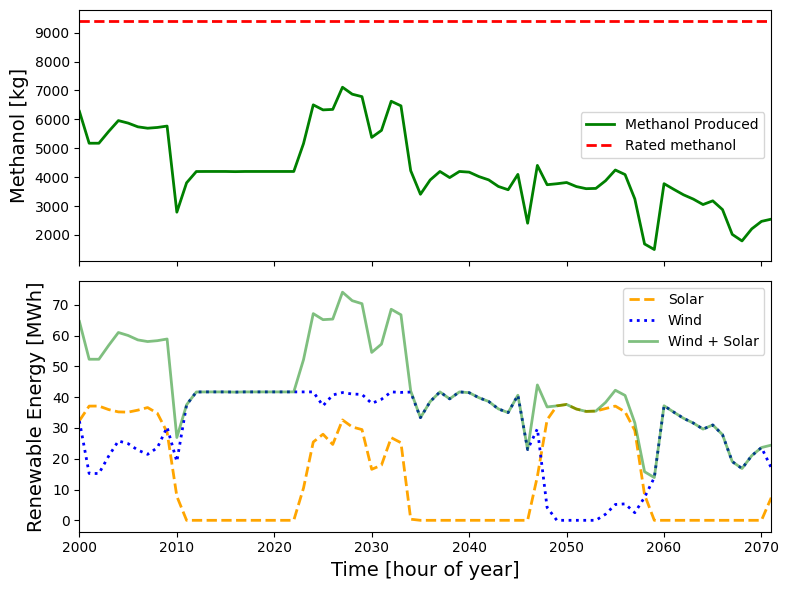

In [26]:
hour_start = 2000
n_hours = 72
hour_end = hour_start + n_hours

fig,ax=plt.subplots(2,1,sharex=True)
fig.set_figwidth(8.0)
fig.set_figheight(6.0)

ax[0].plot(hours_of_year[hour_start:hour_end],methanol_production_kg_pr_hr[hour_start:hour_end],lw=2,c='green',label='Methanol Produced')
ax[0].plot(hours_of_year[hour_start:hour_end],max_meoh_pr_hr*np.ones(n_hours),lw=2,ls='--',c='red',label='Rated methanol')
ax[0].legend(loc='center right')
ax[0].set_ylabel('Methanol [kg]',fontsize=14)
ax[0].set_xlim((hour_start,hour_end-1))

ax[1].plot(hours_of_year[hour_start:hour_end],solar_plant_power[hour_start:hour_end]/1e3,lw=2,ls='--',c='orange',label='Solar')
ax[1].plot(hours_of_year[hour_start:hour_end],wind_plant_power[hour_start:hour_end]/1e3,lw=2,ls=':',c='blue',label='Wind')
ax[1].plot(hours_of_year[hour_start:hour_end],hybrid_plant_generation_profile[hour_start:hour_end]/1e3,lw=2,alpha=0.5,c='green',label='Wind + Solar')
ax[1].set_ylabel('Renewable Energy [MWh]',fontsize=14)
ax[1].set_xlabel('Time [hour of year]',fontsize=14)
ax[1].set_xlim((hour_start,hour_end-1))
ax[1].legend()
fig.tight_layout()